# Statistik-Projekt HS25 – Notebook 08: Hypothesentest II (Verkehrsmittel)
## Forschungsfrage
Hat der Zugtyp (Fernverkehr vs. S-Bahn vs. Regionalverkehr) einen signifikanten Einfluss auf die Verspätung?
Oft wird angenommen, dass S-Bahnen aufgrund der vielen Halte anfälliger für Verspätungen sind, während Fernverkehrszüge (IC/IR) Priorität im Netz haben.

## Hypothesen
* $H_0$: Die Verteilung der Verspätungen ist für alle Zugtypen gleich. ($\mu_{IC} = \mu_{S-Bahn} = \dots$)
* $H_1$: Es gibt signifikante Unterschiede zwischen den Zugtypen.

## Methode
Da wir mehr als zwei Gruppen haben ("Fernverkehr", "Regional", "S-Bahn", "Andere") und die Daten nicht normalverteilt sind, nutzen wir erneut den **Kruskal-Wallis-Test**.
Bei Signifikanz führen wir **Post-hoc-Tests** durch, um zu sehen, *welche* Typen sich unterscheiden.

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"

# 2. Daten laden
print(f"Lade Daten aus {INPUT_PATH}...")
df = pl.read_parquet(INPUT_PATH)

# Sample ziehen für Performance (200.000 Zeilen)
# Ein Sample ist notwendig, da p-Werte bei 60 Mio. Datenpunkten fast immer "0.0" sind (zu sensitiv).
# 200k ist ein guter Kompromiss aus Rechenzeit und Genauigkeit.
df_sample = df.sample(n=200000, seed=42).to_pandas()
print(f"Arbeite mit Stichprobe: {len(df_sample)} Zeilen.")

# Check der Gruppen
print("\nVerteilung der Zugtypen im Sample:")
print(df_sample["linientyp"].value_counts())

Lade Daten aus ../../data/processed/istdata_clean_extended.parquet...
Arbeite mit Stichprobe: 200000 Zeilen.

Verteilung der Zugtypen im Sample:
linientyp
S-Bahn         129610
Regional        52352
Fernverkehr     14047
Andere           3991
Name: count, dtype: int64


In [2]:
# Gruppen extrahieren
types = df_sample["linientyp"].unique()
groups = [df_sample[df_sample["linientyp"] == t]["arr_delay_min"].values for t in types]

# Test durchführen
stat, p_value = kruskal(*groups)

print(f"--- Kruskal-Wallis Test (Verkehrsmittel) ---")
print(f"H-Statistik: {stat:.2f}")
print(f"p-Wert:      {p_value:.4e}") 

if p_value < 0.05:
    print("\nERGEBNIS: H0 abgelehnt. Der Zugtyp hat einen signifikanten Einfluss auf die Verspätung.")
else:
    print("\nERGEBNIS: H0 angenommen. Keine signifikanten Unterschiede zwischen den Typen.")

# Effektstärke (Epsilon-Squared)
n = len(df_sample)
k = len(types)
epsilon2 = (stat - k + 1) / (n - k)

print(f"Effektstärke (Epsilon²): {epsilon2:.4f}")

--- Kruskal-Wallis Test (Verkehrsmittel) ---
H-Statistik: 853.42
p-Wert:      1.1242e-184

ERGEBNIS: H0 abgelehnt. Der Zugtyp hat einen signifikanten Einfluss auf die Verspätung.
Effektstärke (Epsilon²): 0.0043


In [3]:
print("--- Post-hoc Tests (Paarweise Vergleiche) ---")

# Alle möglichen Paare bilden
pairs = list(combinations(types, 2))
results = []

for t1, t2 in pairs:
    group1 = df_sample[df_sample["linientyp"] == t1]["arr_delay_min"]
    group2 = df_sample[df_sample["linientyp"] == t2]["arr_delay_min"]
    
    # Mann-Whitney U Test
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    
    results.append({
        "Vergleich": f"{t1} vs {t2}",
        "p_raw": p,
        "Median_Diff": group1.median() - group2.median()
    })

# Ergebnisse in DataFrame umwandeln
df_results = pd.DataFrame(results)

# P-Wert Korrektur (Benjamini-Hochberg)
reject, p_corrected, _, _ = multipletests(df_results["p_raw"], method='fdr_bh')
df_results["p_adj"] = p_corrected
df_results["Signifikant"] = reject

# Schönere Anzeige
display(df_results.sort_values("p_adj"))

print("\nLesehilfe:")
print("- Ist 'p_adj' < 0.05, ist der Unterschied statistisch signifikant.")
print("- 'Median_Diff' zeigt, wie viel Minuten der erste Typ im Median schlechter/besser ist.")

--- Post-hoc Tests (Paarweise Vergleiche) ---


,Vergleich,p_raw,Median_Diff,p_adj,Signifikant
2,S-Bahn vs Fernverkehr,8.696258e-151,0.250000,5.217755e-150,True
0,S-Bahn vs Regional,3.466493e-57,0.083333,1.039948e-56,True
4,Regional vs Fernverkehr,1.135286e-40,0.166667,2.270571e-40,True
1,S-Bahn vs Andere,6.351559e-25,0.483333,9.527339e-25,True
5,Andere vs Fernverkehr,3.002344e-07,-0.233333,3.602813e-07,True
3,Regional vs Andere,3.157356e-02,0.400000,3.157356e-02,True



Lesehilfe:
- Ist 'p_adj' < 0.05, ist der Unterschied statistisch signifikant.
- 'Median_Diff' zeigt, wie viel Minuten der erste Typ im Median schlechter/besser ist.


/tmp/ipykernel_19537/3266074598.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


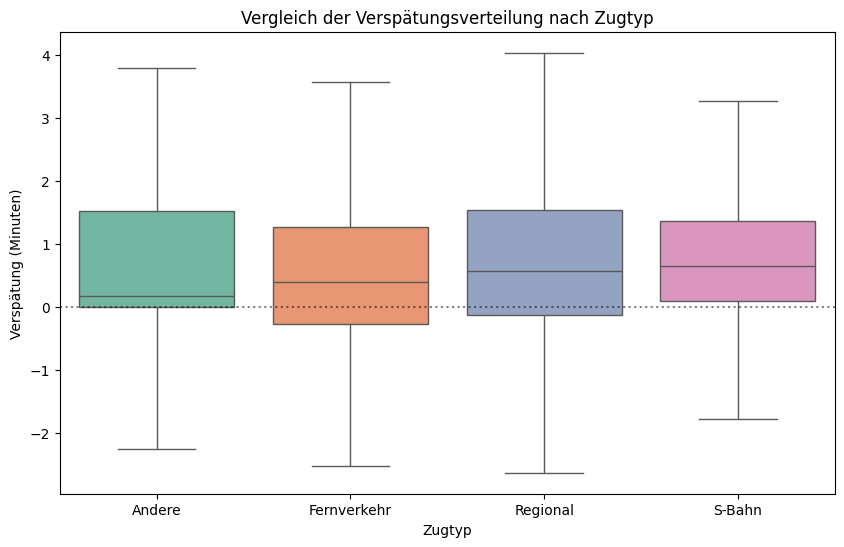

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Sortieren nach Median-Verspätung für bessere Lesbarkeit
order = df_sample.groupby("linientyp")["arr_delay_min"].median().sort_values().index

sns.boxplot(
    data=df_sample,
    x="linientyp",
    y="arr_delay_min",
    order=order,
    showfliers=False, # Fokus auf die Boxen
    palette="Set2"
)

plt.title("Vergleich der Verspätungsverteilung nach Zugtyp")
plt.ylabel("Verspätung (Minuten)")
plt.xlabel("Zugtyp")
plt.axhline(0, color='black', linestyle=':', alpha=0.5)
plt.show()